In [1]:
'''
 *
 * Name                   :   ANN Optimisation using PSO Algorithm
 *
 * Description            :   This Project is 3 folded.
 *                                1. Building MLP 
 *                                2. Implementing PSO for Optimising the ANN
 *                                3. Experiments with varying Hyperparameter values. 
 *                      
 * Authors                :  Shreyas Arunesh
 *
 *
'''

'\n *\n * Name                   :   ANN Optimisation using PSO Algorithm\n *\n * Description            :   This Project is 3 folded.\n *                                1. Building MLP \n *                                2. Implementing PSO for Optimising the ANN\n *                                3. Experiments with varying Hyperparameters\n *                      \n * Authors                :  Shreyas Arunesh\n *\n *\n'

In [2]:
'''importing packages'''
from typing import Tuple, Sequence, Callable, TypeVar
import numpy as np
from random import randrange, uniform, seed
import matplotlib.pyplot as plt
import math
import csv
import os
import sys

In [3]:
'''storing the dataset path to a list'''
datasets = [ os.getcwd()+"/dataset/data_banknote_authentication.txt"]

In [4]:
'''defining the input type for the activation functions'''
Param = TypeVar("Param", float, np.ndarray)


def null(x: Param) -> Param:
    '''
     *
     *  Summary : this block implements null function
     *
     *  Args    : Param - float - np.ndarray
     *
     *  Returns : it returns zero 
     *
     '''
    return 0



def sigmoid(x: Param) -> Param:
    
     '''
     *
     *  Summary : this block implements sigmoid function
     *
     *  Args    : Param - float - np.ndarray
     *
     *  Returns : it returns sigmoid of 'x' 
     *
     '''
     return 1/(1+np.exp(-x))

def hyperbolicTangent(x: Param) -> Param:
    '''
     *
     *  Summary : this block implements hyperbolic tangent function
     *
     *  Args    : Param - float - np.ndarray
     *
     *  Returns : it returns hyperbolic tangent of 'x' 
     *
     '''
    return np.tanh(x)

def relu(x: Param)-> Param:
    '''
     *
     *  Summary : this block implements relu function
     *
     *  Args    : Param - input 'x'
     *
     *  Returns : it returns maximium of 'x' or '0' 
     *
     '''
    return np.maximum(x,0)

def gaussian(x: Param) -> Param:
    '''
     *
     *  Summary : this block implements gaussian function
     *
     *  Args    : Param - float - np.ndarray
     *
     *  Returns : it returns gaussian of 'x' 
     *
     '''
    return np.exp(-(pow(x,2)/2))


In [5]:
ActivationFn = Callable[[float], float]


class Layer:
    """
    *
    * Summary :    This class implements a single layer of the Network.
    *
    """
    
    def __init__(self, perceptron_nb: int, activation: ActivationFn, input_nb=0) -> None:
        
        '''
         *
         *  Summary : this block implements the constructor for the class
         *
         *  Args    : perceptron_nb     -              int         - Number of neurons in layer, which is also the shape 
         *                                                           of the layer's output        
         *        
         *            activation        -    Activation function   - it defines the activation function
         *
         *            input_nb          -              int         - Should be only provided for the first layer of the 
         *                                                           perceptron It gives the expected input shape. 
         *                                                           This is automatically computed for all the other 
         *                                                           layers and should be left at 0 for all layers that 
         *                                                           are not the first one.
         *
         *
         *  Returns : no return value
         *
        '''
     
        self.__shape: Tuple[int, int] = (perceptron_nb, input_nb)
        self.__set_shape([input_nb, perceptron_nb])
        self.activation = activation

    def __set_shape(self, new_shape: Tuple[int, int]) -> None:
        
        '''
         *
         *  Summary : this function sets the shape of the layer. When the shape of the layer is modified, the weights 
         *            are modified too to keep the layer fully connected with the previous layer.
         *
         *  Args    : new_shape   -   Tuple[int, int]   -   this defines the input and output shape
         *                                                  shape[0]: shape of the layer's input
         *                                                  shape[1]: shape of the layer's output         
         *        
         *  Returns : no return value
         *
        '''

        # self.weights = np.random.rand(new_shape[0], new_shape[1])
        self.weights = np.full((new_shape[1], new_shape[0] + 1), 1.) # add 1 to new_shape[0] for the bias
        self.__shape = new_shape

    
    def __get_shape(self) -> Tuple[int, int]:
        
        '''
         *
         *  Summary : This function gets the shape of the layer.
         *
         *  Args    : No Arguments
         * 
         *  Returns : It returns the shape of the layer. 
         *            this defines the input and output shape
         *            shape[0]: shape of the layer's input
         *            shape[1]: shape of the layer's output 
         *
        '''
        return self.__shape


    shape = property(__get_shape, __set_shape)



    def output(self, inputs: np.ndarray) -> np.ndarray:
        
        '''
         *
         *  Summary : This function computes the activation on the output.
         *            activation(dot(weights, inputs) + bias)
         *
         *  Args    : inputs  - np.ndarray  -  numpy array of input values
         * 
         *  Returns : It returns numpy array of output values. 
         *            
         *
        '''

        ''' add 1 to beginning of inputs for the bias '''
        inputs = np.insert(inputs, 0, 1., axis=0)
            
        ''' computes result '''
        fn = lambda i: np.dot(self.weights[i], inputs)
        weighted_sum = np.fromfunction(fn, (self.shape[1],), dtype=int)
        return self.activation(weighted_sum)


In [6]:
class MultiLayerPerceptron:
    """
    *
    * Summary :    This class implements a multiple layers neural network.
    *
    """
    def __init__(self) -> None:
        
        '''
         *
         *  Summary : This block implements the constructor for the class
         *
         *  Args    : No Arguments
         *
         *  Returns : No return value
         *
        '''
        self.layers = np.array([])


    def add_layer(self, new_layer: Layer) -> None:
        
        '''
         *
         *  Summary : This block adds a layer to the neural network.
         *
         *  Args    : new_layer  -  Layer (class)  -  This holds an object of the class 'Layer'.
         *                                            if this holds the first layer, then 'input_nb' must be provided.
         *
         *  Returns : No return value
         *
        '''
            
        ''' if hidden or output layer, set  the input shape to be the output shape of the previous layer'''
        if self.layers.size != 0:
            prev_layer = self.layers[-1]
            if prev_layer.shape[1] != new_layer.shape[0]:
                new_layer.shape = (prev_layer.shape[1], new_layer.shape[1])
        self.layers = np.append(self.layers, new_layer)

    def set_activations(self, fns: np.ndarray):
        for (layer, fn) in zip(self.layers, fns):
            layer.activation = fn

    def set_weights(self, weights: np.ndarray):
        """
         *
         * Summary : set the weights of the neural network
         *
         * Args    : weights  -  The weights to use for the network
         *
         * Returns : No return value.
        """
        for layer in self.layers:
            w = weights[:layer.weights.size]
            w.resize((layer.shape[1], layer.shape[0] + 1))  # add 1 to shape[0] to account for the bias
            layer.weights = w
            weights = weights[layer.shape[0] * layer.shape[1]:]

    @property
    def weights_size(self) -> int:
        """
         *
         * Summary : Return the total number of connections (i.e. the number of weights) in the Network.
         *
         * Args    : No Arguments
         *
         * Returns : Return the total number of connections (i.e. the number of weights) in the Network.
        """
        return sum([layer.weights.size for layer in self.layers])

    @property
    def parameters_size(self) -> int:
        """
         *
         * Summary : Return the total number of parameters to be optimized by the PSO i.e. number of weights + number of layers
         *
         * Args    : No Arguments
         *
         * Returns : Return the total number of parameters to be optimized by the PSO i.e. number of weights + number of layers
        """
        return self.weights_size + self.layers.size

    def evaluate(self, inputs: np.ndarray) -> np.ndarray:
        
        '''
         *
         *  Summary : This block evaluates the output of the network from the provided inputs
         *
         *  Args    : inputs  -  np.adarray  -  It holds the data in the form of numpy array.
         *
         *  Returns : It returns computed outputs of the Neural network
         *
        '''
        # evaluate each layer
        prev_output = inputs
        for layer in self.layers:
            prev_output = layer.output(prev_output)
        return prev_output

    def summary(self) -> None:
        '''
         *
         *  Summary : This block prints out the summary of the Feedforward Neural Network.
         *
         *  Args    : No Arguments
         *
         *  Returns : No Return value.
         *
        '''
        
        print('Total Layers: {}'.format(self.layers.size))
        print('Input Size: {}'.format(self.layers[0].shape[0]))
        i = 0
        for layer in self.layers:
            i += 1
            print('\nLayer #{}: size {}'.format(i, layer.shape[1]))
            print(layer.weights)
            print("Activation Function : " + layer.activation.__name__)



In [7]:
seed(10)

'''initializing the varibles'''
Param = TypeVar('Param')
FitnessFn = Callable[[Param], Param]


def random_particle(dims: int) -> np.array:
    '''
    *
    * Summary  :  it generates random points for the given dimensions.
    *
    * Args     :  dims   -   int    -   it hold the value for the dimensions.
    *
    * Returns  :  it returns random points in the given dimensions
    *
    '''

    return np.array([uniform(0, 1) for _ in range(dims)])

In [8]:
class PSO:
    '''
    *
    * Summary  : this class implements the PSO algorithm.
    *
    '''

    def __init__(self, fitness_fn: FitnessFn, dimensions: int, **kwargs):

        '''
           *
           * Summary  :  constructor to initialize the parameters of the PSO class.
           *
           * Args     :  REQUIRED :
           *                       fitness_fn          -  FitnessFn          -   reference to the function FitnessFn.
           *                       dimensions          -  int                -   it holds the value for the dimension.
           *             OPTIONAL :
           *                       **kwargs            - default parameters  -   default parameters
           *                        swarm_size         - int                 -   it holds the value for population size or swarm size.
           *                        informants_nb      - int                 -   it holds the value for the number of informants.
           *                        inertia            - float               -   it holds the value for inertia
           *                        cognitive_weight   - float               -   it holds the value for cognitive weight
           *                        social_weight      - float               -   it holds the value for social weight
           *                        step_size          - int                 -   it holds the value for step size
           *                        max_velocity       - float               -   it holds the value for maximum velocity of the particles.
           *                        min_velocity       - float               -   it holds the value for minimum velocity of the particles.
           *
           *
           * Returns  :  No return value.
           *
        '''


        parameters = {
            "swarm_size": 10,
            "informants_nb": 3,
            "step_size": 1,
            "inertia": 1,
            "cognitive_weight": 1,
            "social_weight": 1,
            "max_velocity": 1,
            "min_velocity": -1
        }
        for key in parameters:
            if key in kwargs:
                parameters[key] = kwargs[key]

        self.dimensions = dimensions

        """ hyper-parameters initialization """
        self.fitness_fn = fitness_fn
        self.swarm_size = parameters["swarm_size"]
        self.informants_nb = parameters["informants_nb"]
        self.step_size = parameters["step_size"]
        self.inertia = parameters["inertia"]
        self.cognitive_weight = parameters["cognitive_weight"]
        self.social_weight = parameters["social_weight"]
        self.max_v = parameters["max_velocity"]
        self.min_v = parameters["min_velocity"]

        """ particles & velocity vectors initialization"""
        self.particles = np.array([random_particle(dimensions) for _ in range(self.swarm_size)])
        self.velocities = np.array([random_particle(dimensions) - self.particles[i] for i in range(self.swarm_size)])
        self.fitness = np.array([0 for _ in range(self.swarm_size)])
        self.fittest_positions = np.copy(self.particles)
        self.fittest_values = np.array([self.fitness_fn(p) for p in self.particles])
        self.best = random_particle(self.dimensions)
        self.best_value = self.fitness_fn(self.best)

    def get_best_informant(self, index: int) -> np.array:
        '''
           *
           * Summary  :  it returns the best position of random informants for the particle with given index.
           *
           * Args     :  index   -   int    -    it holds the value for informants.
           *
           * Returns  :  it returns the best position of random informants for the particle with given index.
           *
           *
        '''

        informants_id = np.random.choice(range(self.swarm_size), self.informants_nb)
        if index not in informants_id:
            np.append(informants_id, index)
        informants_positions = np.array([self.fittest_positions[i] for i in informants_id])
        informants_values = np.array([self.fittest_values[i] for i in informants_id])
        max_index = np.argmax(informants_values)
        return informants_positions[max_index]

    def update_velocity(self, index: int) -> None:
        '''
           *
           * Summary  :  This function updates the velocity for the particle with given index.
           *
           * Args     :  index   -   int    -   it holds the value for the accessing the particles.
           *
           * Returns  :  No return value.
           *
        '''

        p = self.particles[index]
        a = uniform(0, self.inertia)
        b = uniform(0, self.cognitive_weight)
        c = uniform(0, self.social_weight)
        inertia_vector = a * self.velocities[index]
        cognitive_vector = b * (self.fittest_positions[index] - p)
        best_informant = self.get_best_informant(index)
        social_vector = c * (best_informant - p)
        v = inertia_vector + cognitive_vector + social_vector
        if np.max(v) > self.max_v or np.min(v) < self.min_v:
            v = np.clip(v, self.min_v, self.max_v)
        self.velocities[index] = v

    def update_best(self):
        '''
           *
           * Summary  : This function updates the best position found by the swarm.
           *
           * Args     : No arguments.
           *
           * Returns  : No return value.
           *
        '''

        max_index = np.argmax(self.fitness)
        if self.fitness[max_index] > self.fitness_fn(self.best):
            self.best = self.particles[max_index]
            self.best_value = self.fitness[max_index]

    def update_particles(self):
        '''
           *
           * Summary  : This fucntion updates the best position, velocities, and particles.
           *            It Represents one iteration of the PSO algorithm
           *
           * Args     : No arguments.
           *
           * Returns  : No return value.
           *
        '''


        self.fitness = np.apply_along_axis(self.fitness_fn, axis=1, arr=self.particles)
        # Update best solution
        self.update_best()

        for i in range(self.swarm_size):
            # update velocity
            self.update_velocity(i)
        # update particles positions
        self.particles = self.particles + self.step_size * self.velocities
        # update fittest positions & values for all particles
        for i, p in enumerate(self.particles):
            if self.fitness[i] > self.fittest_values[i]:
                self.fittest_positions[i] = p
                self.fittest_values[i] = self.fitness[i]
                

    def run(self, max_iter=200, precision=5, save_path=None):

        '''
           *
           * Summary  : This function will run the PSO algorithm with the given number of iterations.
           *
           * Args     : max_iter    -     int    -    holds the number of iterations to run on the algorithm.
           *            precision   -     int    -    it defines the precision of the output. default is 5.
           *            save-path   -     var    -    it holds the path to save the output. default is set to Null.
           *
           * Returns  : it returns the best fitness value.
           *
        '''

        convergence = 0
        f = None
        if save_path:
            print(save_path)
            f = open(save_path, 'w+')

        for i in range(max_iter):
            print('------------------- Iteration {} ---------------------------'.format(i))

            self.update_particles()
            print('best fitness: {}'.format(self.best_value))
            if save_path:
                f.write('{}\n'.format(self.best_value[0]))

        return self.best



In [9]:
'''Declaring the Variable'''
activations = [
    sigmoid,
    hyperbolicTangent,
    gaussian
]

def value_to_activation_fn(value: float):
    '''
    *
    *  Summary : This function returns the activation function on input.
    *
    *  Args    : value  -   float    -    value to get the activation function.
    *
    *  Returns : Returns the Activation function.
    *
    '''
    if value < -1:
        value = -1
    elif value > 1:
        value = 1
    index = math.floor(value * len(activations)/2)
    return activations[index]


In [10]:
class MlpOptimizer:
    """
    *
    *  Summary  :  Optimize a MLP to approximate given data
    *
    """
    def __init__(self, mlp: MultiLayerPerceptron, data: np.array):
        '''
        *
        *  Summary : This function initializes the MlpOptimizer.py object .
        *
        *  Args    : mlp    -    MultiLayerPerceptron  -   object of MultiLayerPerceptron
        *            data   -    np.array              -   input data
        *
        *  Returns : No Return Values.
        *
        '''


        self.mlp = mlp
        self.best = None
        self.data = data

        def fitness_fn(position: np.array):
            '''
            *
            *  Summary : This function sets mlp weights & activation functions from position.
            *
            *  Args    : position   -    np.array   -   it holds the positions
            *
            *  Returns : It returns the Mean Square Error.
            *
            '''

            self.set_parameters(position)
            mse = 0
            for d in self.data:
                """ difference between expected and predicted """
                pred = mlp.evaluate(np.array(d[:-1]))
                mse += (pred - d[-1])**2
            mse /= len(self.data)
            return -mse

        self.fitness_fn = fitness_fn

    def set_parameters(self, position: np.ndarray):
        '''
        *
        *  Summary : This function sets mlp weights & activation functions from position.
        *
        *  Args    : position   -    np.array   -   it holds the positions
        *
        *  Returns : No Return Value.
        *
        '''

        """ set activation functions """
        activation_values = position[:self.mlp.layers.size]
        activation_fns = np.array([value_to_activation_fn(val) for val in activation_values])
        self.mlp.set_activations(activation_fns)

        """ set weights """
        weights = position[self.mlp.layers.size:]
        self.mlp.set_weights(weights)

    def optimize(self, max_iterations, file_path='', **pso_params):
        '''
        *
        *  Summary : This function will optimise the given MLP with a PSO and return the final
        *            best MLP's fitness.
        *
        *  Args    :  max_iterations  -    int               -   it holds the value for maximum iterations.
        *             file_path       -   string             -   it holds the path for the file.
        *             **pso_params    -   default parameters -   it holds the default parameters for the pso algorithm.
        *
        *  Returns : It returns the output from the fitness function.
        *
        '''
        pso = PSO(self.fitness_fn, self.mlp.parameters_size, **pso_params)
        self.best = pso.run(max_iterations, 10, save_path=file_path)
        self.set_parameters(self.best)
        return self.fitness_fn(self.best)

# Hyperparameters Experiments 

***Warning = This experiments trains the model for nearly 22 hours. However 
Please check for the output stored in CSV files in the following folders which is used for further visualisation: 
1. informants_nb_experiments
2. swarm_size_experiment 
3. acceleration_coeff_experiment***

In [11]:
def run_experiment(run_path, write_mean, **params):
    '''
    *
    *  Summary : This method will test MLP and PSO on every dataset and writes the data to a file.
    *
    *  Args    : run_path    -  String              -   it holds the path for the files to visualize.
    *            write_mean  -  function            -   its a function to write MSE to the files.
    *            **params    -  default parameters  -   default parameters
    *
    *  Returns : no return value
    *
    '''

    for ds in datasets:
        mse = []
        func_name = "Output"
        for i in range(5):
            mlp = MultiLayerPerceptron()
            mlp.add_layer(Layer(2, hyperbolicTangent, 4))
            mlp.add_layer(Layer(1, hyperbolicTangent))
            mlp.summary()
            data = np.loadtxt(ds,delimiter=',')
            opt = MlpOptimizer(mlp, data)
            file_path = '{}/{}_{}.csv'.format(run_path, func_name, i)
            res = opt.optimize(max_iterations=75, file_path=file_path, **params)
            mse.append(res)
        mean_mse = sum(mse)/len(mse)
        write_mean(func_name, mean_mse)



In [12]:
def run_informants_nb(range_start, range_end, **params):
    '''
    *
    *  Summary : This method will test MLP and PSO on every dataset with different Hyper-parameters.
    *            it takes in a range i.e. start and end values and tests within the given range.
    *            this method conducts experiments varying the number of informants in even numbers. 
    *
    *  Args    : range_start   -   var                -   it holds the initial value to start testing the algorithms.
    *            range_end     -   var                -   it holds the highest value to end testing the algorithms.
    *            **params      -  default parameters  -   default parameters
    *
    *  Returns : no return value
    *
    '''

    r = [x for x in range(range_start, range_end,2)]
    experiment_path = './informants_nb_experiment'
    if not os.path.isdir(experiment_path):
        os.mkdir(experiment_path)

    for i in r:
        params['informants_nb'] = i
        run_path = '{}/informants_{}'.format(experiment_path, i)

        def write_mean(func_name, mean_mse):
            mean_path = '{}/{}_mean_mse.csv'.format(experiment_path, func_name)
            with open(mean_path, 'a+') as f:
                f.write('{}, {}\n'.format(i, mean_mse[0]))

        if not os.path.isdir(run_path):
            os.mkdir(run_path)
        run_experiment(run_path, write_mean, **params)

In [13]:
run_informants_nb(2, 10, swarm_size=100)

Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./informants_nb_experiment/informants_2/Output_0.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.27620855]
------------------- Iteration 1 ---------------------------
best fitness: [-0.21564986]
------------------- Iteration 2 ---------------------------
best fitness: [-0.16065213]
------------------- Iteration 3 ---------------------------
best fitness: [-0.16065213]
------------------- Iteration 4 ---------------------------
best fitness: [-0.16065213]
------------------- Iteration 5 ---------------------------
best fitness: [-0.16065213]
------------------- Iteration 6 ---------------------------
best fitness: [-0.14760382]
------------------- Iteration 7 ---------------------------
best fitness: [-0.14760382]
------------------- Iteration 8 ---------------

best fitness: [-0.0854717]
------------------- Iteration 13 ---------------------------
best fitness: [-0.07853666]
------------------- Iteration 14 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 15 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 16 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 17 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 18 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 19 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 20 ---------------------------
best fitness: [-0.06936353]
------------------- Iteration 21 ---------------------------
best fitness: [-0.06549121]
------------------- Iteration 22 ---------------------------
best fitness: [-0.06549121]
------------------- Iteration 23 ---------------------------
best fitness: [-0.0654

best fitness: [-0.09903967]
------------------- Iteration 28 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 29 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 30 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 31 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 32 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 33 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 34 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 35 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 36 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 37 ---------------------------
best fitness: [-0.09903967]
------------------- Iteration 38 ---------------------------
best fitness: [-0.099

best fitness: [-0.07716462]
------------------- Iteration 43 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 44 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 45 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 46 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 47 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 48 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 49 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 50 ---------------------------
best fitness: [-0.07716462]
------------------- Iteration 51 ---------------------------
best fitness: [-0.06329187]
------------------- Iteration 52 ---------------------------
best fitness: [-0.06329187]
------------------- Iteration 53 ---------------------------
best fitness: [-0.063

best fitness: [-0.0445533]
------------------- Iteration 58 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 59 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 60 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 61 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 62 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 63 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 64 ---------------------------
best fitness: [-0.0445533]
------------------- Iteration 65 ---------------------------
best fitness: [-0.04416078]
------------------- Iteration 66 ---------------------------
best fitness: [-0.04416078]
------------------- Iteration 67 ---------------------------
best fitness: [-0.04416078]
------------------- Iteration 68 ---------------------------
best fitness: [-0.04416078]
-

best fitness: [-0.01640899]
------------------- Iteration 73 ---------------------------
best fitness: [-0.01640899]
------------------- Iteration 74 ---------------------------
best fitness: [-0.01640899]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./informants_nb_experiment/informants_4/Output_1.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.27532273]
------------------- Iteration 1 ---------------------------
best fitness: [-0.18409652]
------------------- Iteration 2 ---------------------------
best fitness: [-0.18409652]
------------------- Iteration 3 ---------------------------
best fitness: [-0.11844895]
------------------- Iteration 4 ---------------------------
best fitness: [-0.11844895]
------------------- Iteration 5 ---------------------------
best fitness: [-0.11844895]
-----------------

best fitness: [-0.14115196]
------------------- Iteration 10 ---------------------------
best fitness: [-0.14023228]
------------------- Iteration 11 ---------------------------
best fitness: [-0.14023228]
------------------- Iteration 12 ---------------------------
best fitness: [-0.14023228]
------------------- Iteration 13 ---------------------------
best fitness: [-0.13090224]
------------------- Iteration 14 ---------------------------
best fitness: [-0.12462242]
------------------- Iteration 15 ---------------------------
best fitness: [-0.12462242]
------------------- Iteration 16 ---------------------------
best fitness: [-0.11931504]
------------------- Iteration 17 ---------------------------
best fitness: [-0.11742283]
------------------- Iteration 18 ---------------------------
best fitness: [-0.11742283]
------------------- Iteration 19 ---------------------------
best fitness: [-0.11742283]
------------------- Iteration 20 ---------------------------
best fitness: [-0.117

best fitness: [-0.01493432]
------------------- Iteration 25 ---------------------------
best fitness: [-0.01493432]
------------------- Iteration 26 ---------------------------
best fitness: [-0.01394565]
------------------- Iteration 27 ---------------------------
best fitness: [-0.01394565]
------------------- Iteration 28 ---------------------------
best fitness: [-0.01394565]
------------------- Iteration 29 ---------------------------
best fitness: [-0.01394565]
------------------- Iteration 30 ---------------------------
best fitness: [-0.01394565]
------------------- Iteration 31 ---------------------------
best fitness: [-0.01394565]
------------------- Iteration 32 ---------------------------
best fitness: [-0.01283306]
------------------- Iteration 33 ---------------------------
best fitness: [-0.01177696]
------------------- Iteration 34 ---------------------------
best fitness: [-0.01155794]
------------------- Iteration 35 ---------------------------
best fitness: [-0.011

best fitness: [-0.05222195]
------------------- Iteration 40 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 41 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 42 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 43 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 44 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 45 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 46 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 47 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 48 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 49 ---------------------------
best fitness: [-0.05222195]
------------------- Iteration 50 ---------------------------
best fitness: [-0.052

best fitness: [-0.05267864]
------------------- Iteration 55 ---------------------------
best fitness: [-0.05267864]
------------------- Iteration 56 ---------------------------
best fitness: [-0.05243626]
------------------- Iteration 57 ---------------------------
best fitness: [-0.0522066]
------------------- Iteration 58 ---------------------------
best fitness: [-0.0522066]
------------------- Iteration 59 ---------------------------
best fitness: [-0.0522066]
------------------- Iteration 60 ---------------------------
best fitness: [-0.0522066]
------------------- Iteration 61 ---------------------------
best fitness: [-0.0522066]
------------------- Iteration 62 ---------------------------
best fitness: [-0.0522066]
------------------- Iteration 63 ---------------------------
best fitness: [-0.05163019]
------------------- Iteration 64 ---------------------------
best fitness: [-0.05163019]
------------------- Iteration 65 ---------------------------
best fitness: [-0.05163019]

best fitness: [-0.06150171]
------------------- Iteration 70 ---------------------------
best fitness: [-0.06150171]
------------------- Iteration 71 ---------------------------
best fitness: [-0.06150171]
------------------- Iteration 72 ---------------------------
best fitness: [-0.06150171]
------------------- Iteration 73 ---------------------------
best fitness: [-0.06114446]
------------------- Iteration 74 ---------------------------
best fitness: [-0.06114446]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./informants_nb_experiment/informants_6/Output_2.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.28466032]
------------------- Iteration 1 ---------------------------
best fitness: [-0.2448539]
------------------- Iteration 2 ---------------------------
best fitness: [-0.21738527]
---------------

best fitness: [-0.1478343]
------------------- Iteration 7 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 8 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 9 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 10 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 11 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 12 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 13 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 14 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 15 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 16 ---------------------------
best fitness: [-0.1478343]
------------------- Iteration 17 ---------------------------
best fitness: [-0.1478343]
--------

best fitness: [-0.06364517]
------------------- Iteration 22 ---------------------------
best fitness: [-0.06364517]
------------------- Iteration 23 ---------------------------
best fitness: [-0.06364517]
------------------- Iteration 24 ---------------------------
best fitness: [-0.06364517]
------------------- Iteration 25 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 26 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 27 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 28 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 29 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 30 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 31 ---------------------------
best fitness: [-0.05144685]
------------------- Iteration 32 ---------------------------
best fitness: [-0.051

best fitness: [-0.0575801]
------------------- Iteration 37 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 38 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 39 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 40 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 41 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 42 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 43 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 44 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 45 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 46 ---------------------------
best fitness: [-0.0575801]
------------------- Iteration 47 ---------------------------
best fitness: [-0.0575801]
-----

best fitness: [-0.05370325]
------------------- Iteration 52 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 53 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 54 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 55 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 56 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 57 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 58 ---------------------------
best fitness: [-0.05370325]
------------------- Iteration 59 ---------------------------
best fitness: [-0.05357978]
------------------- Iteration 60 ---------------------------
best fitness: [-0.05357978]
------------------- Iteration 61 ---------------------------
best fitness: [-0.05357978]
------------------- Iteration 62 ---------------------------
best fitness: [-0.053

best fitness: [-0.04232934]
------------------- Iteration 67 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 68 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 69 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 70 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 71 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 72 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 73 ---------------------------
best fitness: [-0.04186018]
------------------- Iteration 74 ---------------------------
best fitness: [-0.04186018]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./informants_nb_experiment/informants_8/Output_3.csv
-----------

best fitness: [-0.20664394]
------------------- Iteration 4 ---------------------------
best fitness: [-0.18730072]
------------------- Iteration 5 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 6 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 7 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 8 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 9 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 10 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 11 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 12 ---------------------------
best fitness: [-0.16612606]
------------------- Iteration 13 ---------------------------
best fitness: [-0.11003376]
------------------- Iteration 14 ---------------------------
best fitness: [-0.11003376]

In [14]:
def run_swarm_size(value_range, **params):
    '''
        *
        *  Summary : This method will test MLP and PSO on every dataset with different Hyper-parameters.
        *            it takes in a range value and tests within the given range.
        *            this method conducts experiments varying the swarm size.
        *
        *  Args    : value_range   -   var                -   it holds the highest value to end testing the algorithms.
        *            **params      -  default parameters  -   default parameters
        *
        *  Returns : no return value
        *
    '''
    experiment_path = './swarm_size_experiment'
    if not os.path.isdir(experiment_path):
        os.mkdir(experiment_path)

    for i in value_range:
        params['swarm_size'] = i
        run_path = '{}/swarm_size_{}'.format(experiment_path, i)

        def write_mean(func_name, mean_mse):
            mean_path = '{}/{}_mean_mse.csv'.format(experiment_path, func_name)
            with open(mean_path, 'a+') as f:
                f.write('{}, {}\n'.format(i, mean_mse[0]))

        if not os.path.isdir(run_path):
            os.mkdir(run_path)
        run_experiment(run_path, write_mean, **params)

In [15]:
run_swarm_size([1, 20, 50, 100,200, 500])

Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./swarm_size_experiment/swarm_size_1/Output_0.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.40705787]
------------------- Iteration 1 ---------------------------
best fitness: [-0.39885161]
------------------- Iteration 2 ---------------------------
best fitness: [-0.39097455]
------------------- Iteration 3 ---------------------------
best fitness: [-0.39097455]
------------------- Iteration 4 ---------------------------
best fitness: [-0.39097455]
------------------- Iteration 5 ---------------------------
best fitness: [-0.39097455]
------------------- Iteration 6 ---------------------------
best fitness: [-0.39097455]
------------------- Iteration 7 ---------------------------
best fitness: [-0.39097455]
------------------- Iteration 8 ------------------

best fitness: [-0.3254877]
------------------- Iteration 13 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 14 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 15 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 16 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 17 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 18 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 19 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 20 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 21 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 22 ---------------------------
best fitness: [-0.3254877]
------------------- Iteration 23 ---------------------------
best fitness: [-0.3254877]
-----

best fitness: [-0.35819485]
------------------- Iteration 32 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 33 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 34 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 35 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 36 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 37 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 38 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 39 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 40 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 41 ---------------------------
best fitness: [-0.35819485]
------------------- Iteration 42 ---------------------------
best fitness: [-0.358

best fitness: [-0.40707309]
------------------- Iteration 50 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 51 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 52 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 53 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 54 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 55 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 56 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 57 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 58 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 59 ---------------------------
best fitness: [-0.40707309]
------------------- Iteration 60 ---------------------------
best fitness: [-0.407

best fitness: [-0.41355584]
------------------- Iteration 65 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 66 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 67 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 68 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 69 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 70 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 71 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 72 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 73 ---------------------------
best fitness: [-0.41355584]
------------------- Iteration 74 ---------------------------
best fitness: [-0.41355584]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.

best fitness: [-0.22249176]
------------------- Iteration 2 ---------------------------
best fitness: [-0.22249176]
------------------- Iteration 3 ---------------------------
best fitness: [-0.21788568]
------------------- Iteration 4 ---------------------------
best fitness: [-0.21788568]
------------------- Iteration 5 ---------------------------
best fitness: [-0.21788568]
------------------- Iteration 6 ---------------------------
best fitness: [-0.11883997]
------------------- Iteration 7 ---------------------------
best fitness: [-0.11883997]
------------------- Iteration 8 ---------------------------
best fitness: [-0.11883997]
------------------- Iteration 9 ---------------------------
best fitness: [-0.11883997]
------------------- Iteration 10 ---------------------------
best fitness: [-0.11883997]
------------------- Iteration 11 ---------------------------
best fitness: [-0.11883997]
------------------- Iteration 12 ---------------------------
best fitness: [-0.11883997]
-

best fitness: [-0.1452362]
------------------- Iteration 17 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 18 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 19 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 20 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 21 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 22 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 23 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 24 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 25 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 26 ---------------------------
best fitness: [-0.1452362]
------------------- Iteration 27 ---------------------------
best fitness: [-0.1452362]
-----

best fitness: [-0.15079911]
------------------- Iteration 32 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 33 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 34 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 35 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 36 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 37 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 38 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 39 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 40 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 41 ---------------------------
best fitness: [-0.15079911]
------------------- Iteration 42 ---------------------------
best fitness: [-0.150

best fitness: [-0.10016156]
------------------- Iteration 47 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 48 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 49 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 50 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 51 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 52 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 53 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 54 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 55 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 56 ---------------------------
best fitness: [-0.10016156]
------------------- Iteration 57 ---------------------------
best fitness: [-0.100

best fitness: [-0.07214534]
------------------- Iteration 62 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 63 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 64 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 65 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 66 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 67 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 68 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 69 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 70 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 71 ---------------------------
best fitness: [-0.07214534]
------------------- Iteration 72 ---------------------------
best fitness: [-0.066

./swarm_size_experiment/swarm_size_50/Output_2.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.26747662]
------------------- Iteration 1 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 2 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 3 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 4 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 5 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 6 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 7 ---------------------------
best fitness: [-0.19102304]
------------------- Iteration 8 ---------------------------
best fitness: [-0.1641704]
------------------- Iteration 9 ---------------------------
best fitness: [-0.1641704]
------------------- Iteration 10 ---------------------------
best fitne

best fitness: [-0.12245786]
------------------- Iteration 15 ---------------------------
best fitness: [-0.1223221]
------------------- Iteration 16 ---------------------------
best fitness: [-0.1223221]
------------------- Iteration 17 ---------------------------
best fitness: [-0.1223221]
------------------- Iteration 18 ---------------------------
best fitness: [-0.1223221]
------------------- Iteration 19 ---------------------------
best fitness: [-0.10021762]
------------------- Iteration 20 ---------------------------
best fitness: [-0.10021762]
------------------- Iteration 21 ---------------------------
best fitness: [-0.10021762]
------------------- Iteration 22 ---------------------------
best fitness: [-0.10021762]
------------------- Iteration 23 ---------------------------
best fitness: [-0.10021762]
------------------- Iteration 24 ---------------------------
best fitness: [-0.10021762]
------------------- Iteration 25 ---------------------------
best fitness: [-0.1002176

best fitness: [-0.08894001]
------------------- Iteration 30 ---------------------------
best fitness: [-0.06201199]
------------------- Iteration 31 ---------------------------
best fitness: [-0.06201199]
------------------- Iteration 32 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 33 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 34 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 35 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 36 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 37 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 38 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 39 ---------------------------
best fitness: [-0.05758904]
------------------- Iteration 40 ---------------------------
best fitness: [-0.057

best fitness: [-0.11745378]
------------------- Iteration 45 ---------------------------
best fitness: [-0.11745378]
------------------- Iteration 46 ---------------------------
best fitness: [-0.11745378]
------------------- Iteration 47 ---------------------------
best fitness: [-0.11707941]
------------------- Iteration 48 ---------------------------
best fitness: [-0.11260538]
------------------- Iteration 49 ---------------------------
best fitness: [-0.11260538]
------------------- Iteration 50 ---------------------------
best fitness: [-0.11260538]
------------------- Iteration 51 ---------------------------
best fitness: [-0.11260538]
------------------- Iteration 52 ---------------------------
best fitness: [-0.11260538]
------------------- Iteration 53 ---------------------------
best fitness: [-0.08170038]
------------------- Iteration 54 ---------------------------
best fitness: [-0.08170038]
------------------- Iteration 55 ---------------------------
best fitness: [-0.081

best fitness: [-0.07027506]
------------------- Iteration 60 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 61 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 62 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 63 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 64 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 65 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 66 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 67 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 68 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 69 ---------------------------
best fitness: [-0.07027506]
------------------- Iteration 70 ---------------------------
best fitness: [-0.070

best fitness: [-0.08633126]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./swarm_size_experiment/swarm_size_100/Output_3.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.28946533]
------------------- Iteration 1 ---------------------------
best fitness: [-0.17614189]
------------------- Iteration 2 ---------------------------
best fitness: [-0.16986942]
------------------- Iteration 3 ---------------------------
best fitness: [-0.12392699]
------------------- Iteration 4 ---------------------------
best fitness: [-0.12392699]
------------------- Iteration 5 ---------------------------
best fitness: [-0.12392699]
------------------- Iteration 6 ---------------------------
best fitness: [-0.12392699]
------------------- Iteration 7 ---------------------------
best fitness: [-0.12392699]
------------------- 

best fitness: [-0.14374364]
------------------- Iteration 12 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 13 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 14 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 15 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 16 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 17 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 18 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 19 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 20 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 21 ---------------------------
best fitness: [-0.14374364]
------------------- Iteration 22 ---------------------------
best fitness: [-0.143

best fitness: [-0.03498685]
------------------- Iteration 27 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 28 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 29 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 30 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 31 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 32 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 33 ---------------------------
best fitness: [-0.03498685]
------------------- Iteration 34 ---------------------------
best fitness: [-0.0336784]
------------------- Iteration 35 ---------------------------
best fitness: [-0.0336784]
------------------- Iteration 36 ---------------------------
best fitness: [-0.0336784]
------------------- Iteration 37 ---------------------------
best fitness: [-0.033678

best fitness: [-0.06796179]
------------------- Iteration 42 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 43 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 44 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 45 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 46 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 47 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 48 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 49 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 50 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 51 ---------------------------
best fitness: [-0.03955169]
------------------- Iteration 52 ---------------------------
best fitness: [-0.039

best fitness: [-0.03452314]
------------------- Iteration 57 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 58 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 59 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 60 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 61 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 62 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 63 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 64 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 65 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 66 ---------------------------
best fitness: [-0.03452314]
------------------- Iteration 67 ---------------------------
best fitness: [-0.034

best fitness: [-0.02944676]
------------------- Iteration 72 ---------------------------
best fitness: [-0.02944676]
------------------- Iteration 73 ---------------------------
best fitness: [-0.02944676]
------------------- Iteration 74 ---------------------------
best fitness: [-0.02944676]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./swarm_size_experiment/swarm_size_200/Output_4.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.27570142]
------------------- Iteration 1 ---------------------------
best fitness: [-0.20183442]
------------------- Iteration 2 ---------------------------
best fitness: [-0.14052968]
------------------- Iteration 3 ---------------------------
best fitness: [-0.14052968]
------------------- Iteration 4 ---------------------------
best fitness: [-0.10933208]
-----------------

best fitness: [-0.09646511]
------------------- Iteration 9 ---------------------------
best fitness: [-0.09646511]
------------------- Iteration 10 ---------------------------
best fitness: [-0.08391108]
------------------- Iteration 11 ---------------------------
best fitness: [-0.08391108]
------------------- Iteration 12 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 13 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 14 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 15 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 16 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 17 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 18 ---------------------------
best fitness: [-0.05814837]
------------------- Iteration 19 ---------------------------
best fitness: [-0.0581

best fitness: [-0.04807181]
------------------- Iteration 24 ---------------------------
best fitness: [-0.04807181]
------------------- Iteration 25 ---------------------------
best fitness: [-0.04807181]
------------------- Iteration 26 ---------------------------
best fitness: [-0.04807181]
------------------- Iteration 27 ---------------------------
best fitness: [-0.04594888]
------------------- Iteration 28 ---------------------------
best fitness: [-0.04594888]
------------------- Iteration 29 ---------------------------
best fitness: [-0.04594888]
------------------- Iteration 30 ---------------------------
best fitness: [-0.04594888]
------------------- Iteration 31 ---------------------------
best fitness: [-0.04302614]
------------------- Iteration 32 ---------------------------
best fitness: [-0.04302614]
------------------- Iteration 33 ---------------------------
best fitness: [-0.04302614]
------------------- Iteration 34 ---------------------------
best fitness: [-0.043

best fitness: [-0.04366996]
------------------- Iteration 39 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 40 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 41 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 42 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 43 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 44 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 45 ---------------------------
best fitness: [-0.04366996]
------------------- Iteration 46 ---------------------------
best fitness: [-0.04143004]
------------------- Iteration 47 ---------------------------
best fitness: [-0.04143004]
------------------- Iteration 48 ---------------------------
best fitness: [-0.04143004]
------------------- Iteration 49 ---------------------------
best fitness: [-0.041

best fitness: [-0.03695122]
------------------- Iteration 54 ---------------------------
best fitness: [-0.03695122]
------------------- Iteration 55 ---------------------------
best fitness: [-0.03695122]
------------------- Iteration 56 ---------------------------
best fitness: [-0.03695122]
------------------- Iteration 57 ---------------------------
best fitness: [-0.03695122]
------------------- Iteration 58 ---------------------------
best fitness: [-0.03695122]
------------------- Iteration 59 ---------------------------
best fitness: [-0.03556225]
------------------- Iteration 60 ---------------------------
best fitness: [-0.03556225]
------------------- Iteration 61 ---------------------------
best fitness: [-0.03556225]
------------------- Iteration 62 ---------------------------
best fitness: [-0.03556225]
------------------- Iteration 63 ---------------------------
best fitness: [-0.03556225]
------------------- Iteration 64 ---------------------------
best fitness: [-0.021

best fitness: [-0.03841289]
------------------- Iteration 69 ---------------------------
best fitness: [-0.03841289]
------------------- Iteration 70 ---------------------------
best fitness: [-0.03741902]
------------------- Iteration 71 ---------------------------
best fitness: [-0.03741902]
------------------- Iteration 72 ---------------------------
best fitness: [-0.03741902]
------------------- Iteration 73 ---------------------------
best fitness: [-0.03741902]
------------------- Iteration 74 ---------------------------
best fitness: [-0.03741902]


In [16]:
def run_acceleration_coeff(range_start, range_end, **params):

    '''
    *
    *  Summary : This method will test MLP and PSO on every dataset with different Hyper-parameters.
    *            it takes in a range i.e. start and end values and tests within the given range.
    *            this method conducts experiments varying the number for social and cognitive weights.
    *
    *  Args    : range_start   -   var                -   it holds the initial value to start testing the algorithms.
    *            range_end     -   var                -   it holds the highest value to end testing the algorithms.
    *            **params      -  default parameters  -   default parameters
    *
    *  Returns : no return value
    *
    '''

    r =  np.arange(range_start,range_end,0.5)
    experiment_path = './acceleration_coeff_experiment'
    if not os.path.isdir(experiment_path):
        os.mkdir(experiment_path)

    for i in r:
        params['social_weight'] = i
        params['cognitive_weight'] = 4 - i
        run_path = '{}/acc_coff_{}_{}'.format(experiment_path, i, 4-i)

        def write_mean(func_name, mean_mse):
            mean_path = '{}/{}_mean_mse.csv'.format(experiment_path, func_name)
            with open(mean_path, 'a+') as f:
                f.write('{}, {}, {}\n'.format(i, 4-i, mean_mse[0]))

        if not os.path.isdir(run_path):
            os.mkdir(run_path)
        run_experiment(run_path, write_mean, **params)

In [17]:
run_acceleration_coeff(0, 4, swarm_size=100, informants_nb=5)

Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./acceleration_coeff_experiment/acc_coff_0.0_4.0/Output_0.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.28741236]
------------------- Iteration 1 ---------------------------
best fitness: [-0.28741236]
------------------- Iteration 2 ---------------------------
best fitness: [-0.15902482]
------------------- Iteration 3 ---------------------------
best fitness: [-0.11094784]
------------------- Iteration 4 ---------------------------
best fitness: [-0.11094784]
------------------- Iteration 5 ---------------------------
best fitness: [-0.11094784]
------------------- Iteration 6 ---------------------------
best fitness: [-0.11094784]
------------------- Iteration 7 ---------------------------
best fitness: [-0.11094784]
------------------- Iteration 8 ------

best fitness: [-0.11973779]
------------------- Iteration 12 ---------------------------
best fitness: [-0.11973779]
------------------- Iteration 13 ---------------------------
best fitness: [-0.11973779]
------------------- Iteration 14 ---------------------------
best fitness: [-0.11973779]
------------------- Iteration 15 ---------------------------
best fitness: [-0.11973779]
------------------- Iteration 16 ---------------------------
best fitness: [-0.11329382]
------------------- Iteration 17 ---------------------------
best fitness: [-0.1063354]
------------------- Iteration 18 ---------------------------
best fitness: [-0.10492032]
------------------- Iteration 19 ---------------------------
best fitness: [-0.10433413]
------------------- Iteration 20 ---------------------------
best fitness: [-0.10431195]
------------------- Iteration 21 ---------------------------
best fitness: [-0.10430274]
------------------- Iteration 22 ---------------------------
best fitness: [-0.1042

best fitness: [-0.13171993]
------------------- Iteration 27 ---------------------------
best fitness: [-0.13171993]
------------------- Iteration 28 ---------------------------
best fitness: [-0.13171993]
------------------- Iteration 29 ---------------------------
best fitness: [-0.13171993]
------------------- Iteration 30 ---------------------------
best fitness: [-0.13171993]
------------------- Iteration 31 ---------------------------
best fitness: [-0.13171993]
------------------- Iteration 32 ---------------------------
best fitness: [-0.12473372]
------------------- Iteration 33 ---------------------------
best fitness: [-0.12473372]
------------------- Iteration 34 ---------------------------
best fitness: [-0.12473372]
------------------- Iteration 35 ---------------------------
best fitness: [-0.12473372]
------------------- Iteration 36 ---------------------------
best fitness: [-0.12473372]
------------------- Iteration 37 ---------------------------
best fitness: [-0.124

best fitness: [-0.05492864]
------------------- Iteration 42 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 43 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 44 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 45 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 46 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 47 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 48 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 49 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 50 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 51 ---------------------------
best fitness: [-0.05492864]
------------------- Iteration 52 ---------------------------
best fitness: [-0.054

best fitness: [-0.11844387]
------------------- Iteration 57 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 58 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 59 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 60 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 61 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 62 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 63 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 64 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 65 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 66 ---------------------------
best fitness: [-0.11844387]
------------------- Iteration 67 ---------------------------
best fitness: [-0.118

best fitness: [-0.02730865]
------------------- Iteration 72 ---------------------------
best fitness: [-0.02730865]
------------------- Iteration 73 ---------------------------
best fitness: [-0.02730865]
------------------- Iteration 74 ---------------------------
best fitness: [-0.02730865]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./acceleration_coeff_experiment/acc_coff_0.5_3.5/Output_1.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.28325359]
------------------- Iteration 1 ---------------------------
best fitness: [-0.28325359]
------------------- Iteration 2 ---------------------------
best fitness: [-0.09771135]
------------------- Iteration 3 ---------------------------
best fitness: [-0.09771135]
------------------- Iteration 4 ---------------------------
best fitness: [-0.09771135]
-------

best fitness: [-0.05463638]
------------------- Iteration 9 ---------------------------
best fitness: [-0.05463638]
------------------- Iteration 10 ---------------------------
best fitness: [-0.05463638]
------------------- Iteration 11 ---------------------------
best fitness: [-0.03673094]
------------------- Iteration 12 ---------------------------
best fitness: [-0.03673094]
------------------- Iteration 13 ---------------------------
best fitness: [-0.0349593]
------------------- Iteration 14 ---------------------------
best fitness: [-0.03144891]
------------------- Iteration 15 ---------------------------
best fitness: [-0.03144891]
------------------- Iteration 16 ---------------------------
best fitness: [-0.03144891]
------------------- Iteration 17 ---------------------------
best fitness: [-0.03144891]
------------------- Iteration 18 ---------------------------
best fitness: [-0.03144891]
------------------- Iteration 19 ---------------------------
best fitness: [-0.03144

best fitness: [-0.04547246]
------------------- Iteration 24 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 25 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 26 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 27 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 28 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 29 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 30 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 31 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 32 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 33 ---------------------------
best fitness: [-0.04547246]
------------------- Iteration 34 ---------------------------
best fitness: [-0.045

best fitness: [-0.06341093]
------------------- Iteration 39 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 40 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 41 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 42 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 43 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 44 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 45 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 46 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 47 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 48 ---------------------------
best fitness: [-0.06341093]
------------------- Iteration 49 ---------------------------
best fitness: [-0.063

best fitness: [-0.03107821]
------------------- Iteration 54 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 55 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 56 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 57 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 58 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 59 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 60 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 61 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 62 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 63 ---------------------------
best fitness: [-0.03107821]
------------------- Iteration 64 ---------------------------
best fitness: [-0.031

best fitness: [-0.03493911]
------------------- Iteration 69 ---------------------------
best fitness: [-0.03493911]
------------------- Iteration 70 ---------------------------
best fitness: [-0.03493911]
------------------- Iteration 71 ---------------------------
best fitness: [-0.03493911]
------------------- Iteration 72 ---------------------------
best fitness: [-0.03493911]
------------------- Iteration 73 ---------------------------
best fitness: [-0.03493911]
------------------- Iteration 74 ---------------------------
best fitness: [-0.03493911]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./acceleration_coeff_experiment/acc_coff_1.0_3.0/Output_2.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.28455481]
------------------- Iteration 1 ---------------------------
best fitness: [-0.1760842]
-----

best fitness: [-0.1505264]
------------------- Iteration 6 ---------------------------
best fitness: [-0.07385673]
------------------- Iteration 7 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 8 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 9 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 10 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 11 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 12 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 13 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 14 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 15 ---------------------------
best fitness: [-0.07027218]
------------------- Iteration 16 ---------------------------
best fitness: [-0.06373736

best fitness: [-0.06420511]
------------------- Iteration 21 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 22 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 23 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 24 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 25 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 26 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 27 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 28 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 29 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 30 ---------------------------
best fitness: [-0.06420511]
------------------- Iteration 31 ---------------------------
best fitness: [-0.064

best fitness: [-0.0670366]
------------------- Iteration 36 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 37 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 38 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 39 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 40 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 41 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 42 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 43 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 44 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 45 ---------------------------
best fitness: [-0.0670366]
------------------- Iteration 46 ---------------------------
best fitness: [-0.0670366]
-----

best fitness: [-0.06675388]
------------------- Iteration 51 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 52 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 53 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 54 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 55 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 56 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 57 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 58 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 59 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 60 ---------------------------
best fitness: [-0.06675388]
------------------- Iteration 61 ---------------------------
best fitness: [-0.066

best fitness: [-0.03957285]
------------------- Iteration 66 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 67 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 68 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 69 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 70 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 71 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 72 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 73 ---------------------------
best fitness: [-0.03957285]
------------------- Iteration 74 ---------------------------
best fitness: [-0.03957285]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Func

best fitness: [-0.10493606]
------------------- Iteration 3 ---------------------------
best fitness: [-0.10493606]
------------------- Iteration 4 ---------------------------
best fitness: [-0.10493606]
------------------- Iteration 5 ---------------------------
best fitness: [-0.10493606]
------------------- Iteration 6 ---------------------------
best fitness: [-0.10493606]
------------------- Iteration 7 ---------------------------
best fitness: [-0.10493606]
------------------- Iteration 8 ---------------------------
best fitness: [-0.0794979]
------------------- Iteration 9 ---------------------------
best fitness: [-0.0794979]
------------------- Iteration 10 ---------------------------
best fitness: [-0.0794979]
------------------- Iteration 11 ---------------------------
best fitness: [-0.0794979]
------------------- Iteration 12 ---------------------------
best fitness: [-0.0794979]
------------------- Iteration 13 ---------------------------
best fitness: [-0.0794979]
------

best fitness: [-0.0718614]
------------------- Iteration 18 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 19 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 20 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 21 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 22 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 23 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 24 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 25 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 26 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 27 ---------------------------
best fitness: [-0.0718614]
------------------- Iteration 28 ---------------------------
best fitness: [-0.0718614]
-----

best fitness: [-0.03200604]
------------------- Iteration 33 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 34 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 35 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 36 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 37 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 38 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 39 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 40 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 41 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 42 ---------------------------
best fitness: [-0.03200604]
------------------- Iteration 43 ---------------------------
best fitness: [-0.032

best fitness: [-0.05699613]
------------------- Iteration 48 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 49 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 50 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 51 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 52 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 53 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 54 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 55 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 56 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 57 ---------------------------
best fitness: [-0.05699613]
------------------- Iteration 58 ---------------------------
best fitness: [-0.056

best fitness: [-0.05670708]
------------------- Iteration 63 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 64 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 65 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 66 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 67 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 68 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 69 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 70 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 71 ---------------------------
best fitness: [-0.05670708]
------------------- Iteration 72 ---------------------------
best fitness: [-0.0528258]
------------------- Iteration 73 ---------------------------
best fitness: [-0.0528

./acceleration_coeff_experiment/acc_coff_2.5_1.5/Output_0.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.28887449]
------------------- Iteration 1 ---------------------------
best fitness: [-0.2158167]
------------------- Iteration 2 ---------------------------
best fitness: [-0.13040547]
------------------- Iteration 3 ---------------------------
best fitness: [-0.10471808]
------------------- Iteration 4 ---------------------------
best fitness: [-0.10471808]
------------------- Iteration 5 ---------------------------
best fitness: [-0.10471808]
------------------- Iteration 6 ---------------------------
best fitness: [-0.10471808]
------------------- Iteration 7 ---------------------------
best fitness: [-0.10471808]
------------------- Iteration 8 ---------------------------
best fitness: [-0.10471808]
------------------- Iteration 9 ---------------------------
best fitness: [-0.08710514]
------------------- Iteration 10 --------------------------

best fitness: [-0.05464678]
------------------- Iteration 15 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 16 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 17 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 18 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 19 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 20 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 21 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 22 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 23 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 24 ---------------------------
best fitness: [-0.05464678]
------------------- Iteration 25 ---------------------------
best fitness: [-0.054

best fitness: [-0.05351761]
------------------- Iteration 30 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 31 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 32 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 33 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 34 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 35 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 36 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 37 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 38 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 39 ---------------------------
best fitness: [-0.05351761]
------------------- Iteration 40 ---------------------------
best fitness: [-0.053

best fitness: [-0.04096856]
------------------- Iteration 45 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 46 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 47 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 48 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 49 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 50 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 51 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 52 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 53 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 54 ---------------------------
best fitness: [-0.04096856]
------------------- Iteration 55 ---------------------------
best fitness: [-0.040

best fitness: [-0.0232727]
------------------- Iteration 60 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 61 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 62 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 63 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 64 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 65 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 66 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 67 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 68 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 69 ---------------------------
best fitness: [-0.0232727]
------------------- Iteration 70 ---------------------------
best fitness: [-0.0232727]
-----

best fitness: [-0.04492911]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./acceleration_coeff_experiment/acc_coff_3.0_1.0/Output_1.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.30810306]
------------------- Iteration 1 ---------------------------
best fitness: [-0.12652359]
------------------- Iteration 2 ---------------------------
best fitness: [-0.12652359]
------------------- Iteration 3 ---------------------------
best fitness: [-0.10496805]
------------------- Iteration 4 ---------------------------
best fitness: [-0.10496805]
------------------- Iteration 5 ---------------------------
best fitness: [-0.10496805]
------------------- Iteration 6 ---------------------------
best fitness: [-0.10496805]
------------------- Iteration 7 ---------------------------
best fitness: [-0.10496805]
----------

best fitness: [-0.09646497]
------------------- Iteration 12 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 13 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 14 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 15 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 16 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 17 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 18 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 19 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 20 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 21 ---------------------------
best fitness: [-0.09646497]
------------------- Iteration 22 ---------------------------
best fitness: [-0.096

best fitness: [-0.04316091]
------------------- Iteration 27 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 28 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 29 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 30 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 31 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 32 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 33 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 34 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 35 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 36 ---------------------------
best fitness: [-0.04316091]
------------------- Iteration 37 ---------------------------
best fitness: [-0.043

best fitness: [-0.04752999]
------------------- Iteration 42 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 43 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 44 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 45 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 46 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 47 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 48 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 49 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 50 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 51 ---------------------------
best fitness: [-0.04752999]
------------------- Iteration 52 ---------------------------
best fitness: [-0.047

best fitness: [-0.03804931]
------------------- Iteration 57 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 58 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 59 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 60 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 61 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 62 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 63 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 64 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 65 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 66 ---------------------------
best fitness: [-0.03804931]
------------------- Iteration 67 ---------------------------
best fitness: [-0.038

best fitness: [-0.03131298]
------------------- Iteration 72 ---------------------------
best fitness: [-0.03131298]
------------------- Iteration 73 ---------------------------
best fitness: [-0.03131298]
------------------- Iteration 74 ---------------------------
best fitness: [-0.03131298]
Total Layers: 2
Input Size: 4

Layer #1: size 2
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Activation Function : hyperbolicTangent

Layer #2: size 1
[[1. 1. 1.]]
Activation Function : hyperbolicTangent
./acceleration_coeff_experiment/acc_coff_3.5_0.5/Output_2.csv
------------------- Iteration 0 ---------------------------
best fitness: [-0.27893065]
------------------- Iteration 1 ---------------------------
best fitness: [-0.11521781]
------------------- Iteration 2 ---------------------------
best fitness: [-0.11521781]
------------------- Iteration 3 ---------------------------
best fitness: [-0.11521781]
------------------- Iteration 4 ---------------------------
best fitness: [-0.09579915]
-------

best fitness: [-0.10749112]
------------------- Iteration 9 ---------------------------
best fitness: [-0.10749112]
------------------- Iteration 10 ---------------------------
best fitness: [-0.10749112]
------------------- Iteration 11 ---------------------------
best fitness: [-0.10749112]
------------------- Iteration 12 ---------------------------
best fitness: [-0.07865481]
------------------- Iteration 13 ---------------------------
best fitness: [-0.07865481]
------------------- Iteration 14 ---------------------------
best fitness: [-0.07690794]
------------------- Iteration 15 ---------------------------
best fitness: [-0.06172422]
------------------- Iteration 16 ---------------------------
best fitness: [-0.04534758]
------------------- Iteration 17 ---------------------------
best fitness: [-0.04534758]
------------------- Iteration 18 ---------------------------
best fitness: [-0.04534758]
------------------- Iteration 19 ---------------------------
best fitness: [-0.0453

best fitness: [-0.02696038]
------------------- Iteration 24 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 25 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 26 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 27 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 28 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 29 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 30 ---------------------------
best fitness: [-0.02696038]
------------------- Iteration 31 ---------------------------
best fitness: [-0.02518857]
------------------- Iteration 32 ---------------------------
best fitness: [-0.02518857]
------------------- Iteration 33 ---------------------------
best fitness: [-0.02518857]
------------------- Iteration 34 ---------------------------
best fitness: [-0.025

# Experiments Visualisation

In [19]:
def compare_graphs(file_paths):
    '''
    *
    *  Summary : It visualizes the data in the form of a plot.
    *
    *  Args    : file_paths   -   List   -   it holds the path for the files to visualize.
    *
    *  Returns : no return value
    *
    '''

    data = []
    for file in file_paths:
        with open(file) as f:
            reader = csv.reader(f)
            d = np.array([line for line in reader], dtype=float)
            data.append(d.flatten())
    for index, series in enumerate(data):
        label = file_paths[index].split('/')[-2]
        plt.plot(series[:30], label=label)
    plt.legend(loc="lower right")
    plt.show()


In [69]:

class DataVisualisation:
    '''
    *
    * Summary : This class implements methods to visualize the result of the models.
    *
    '''

    def __init__(self, file_paths):

        '''
        *
        * Summary : This is a constructor that reads the data from file and prepares it
        *           for visualization.
        *
        * Args    : file_paths    -    List    -    it is a list that holds the path of results files.
        *
        * Return  : No Return Value.
        *
        '''
        functions = ["Output"]
        self.file_paths = file_paths
        data = []
        for path in file_paths:
            d = None
            for i in range(5):
                for fn in functions:
                    with open('{}/{}_{}.csv'.format(path, fn, i)) as f:
                        reader = csv.reader(f)
                        run = np.array([line for line in reader], dtype=float)
                        if d is None:
                            d = run.flatten()
                        else:
                            d = np.vstack([d, run.flatten()])
            means = [sum(d[:, i]) / d.shape[0] for i in range(d.shape[1])]
            data.append(means)
        self.data = data

    def plot_speed(self,x_data,title,xlabel,ylabel):

        '''
        *
        * Summary :  This method plots the graph of Fitness vs number iteration.
        *
        * Args    :  No Arguments.
        *
        * Return  :  No Return Value.
        *
        '''
    
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.set_title(title)
        for i, series in enumerate(self.data):
            label = '{}'.format(self.file_paths[i].split("/")[-2])
            plt.plot(series, label=label)
        plt.legend(loc="lower right")
        plt.show()


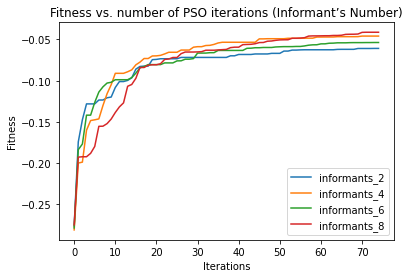

In [71]:

xlabel = "Iterations"
ylabel = "Fitness"
title = "Fitness vs. number of PSO iterations (Informant’s Number)"

paths = [
        'informants_nb_experiment/informants_2/',
        'informants_nb_experiment/informants_4/',
        'informants_nb_experiment/informants_6/',
        'informants_nb_experiment/informants_8/'
    ]
dv = DataVisualisation(paths)
dv.plot_speed([x for x in range(2, 10,2)],title,xlabel,ylabel)

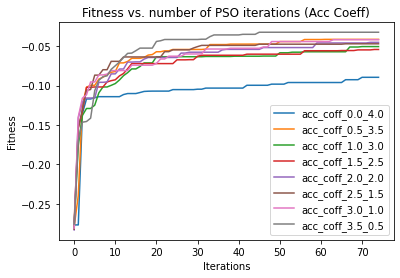

In [72]:


xlabel = "Iterations"
ylabel = "Fitness"
title = "Fitness vs. number of PSO iterations (Acc Coeff)"

paths = [
        'acceleration_coeff_experiment/acc_coff_0.0_4.0/',
        'acceleration_coeff_experiment/acc_coff_0.5_3.5/',
        'acceleration_coeff_experiment/acc_coff_1.0_3.0/',
        'acceleration_coeff_experiment/acc_coff_1.5_2.5/',
        'acceleration_coeff_experiment/acc_coff_2.0_2.0/',
        'acceleration_coeff_experiment/acc_coff_2.5_1.5/',
        'acceleration_coeff_experiment/acc_coff_3.0_1.0/',
        'acceleration_coeff_experiment/acc_coff_3.5_0.5/'
    ]
dv = DataVisualisation(paths)
dv.plot_speed(np.arange(0,4,0.5),title,xlabel,ylabel)


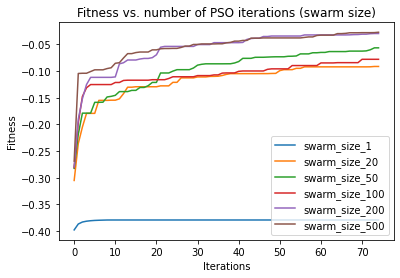

In [73]:

xlabel = "Iterations"
ylabel = "Fitness"
title = "Fitness vs. number of PSO iterations (swarm size)"


paths = [
        'swarm_size_experiment/swarm_size_1/',
        'swarm_size_experiment/swarm_size_20/',
        'swarm_size_experiment/swarm_size_50/',
        'swarm_size_experiment/swarm_size_100/',
        'swarm_size_experiment/swarm_size_200/',
        'swarm_size_experiment/swarm_size_500/',
                


    ]
dv = DataVisualisation(paths)
dv.plot_speed([1,20,50,100,200,500],title,xlabel,ylabel)
